In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, EfficientFrontier

import warnings
warnings.filterwarnings('ignore')

In [22]:
# Define the assets we'll analyze
assets = ['TSLA', 'BND', 'SPY']

# Define the time period
end_date = "2025-01-31"
start_date = "2015-01-01"


# Fetch the data
data = yf.download(assets, start=start_date, end=end_date)
print("\nData shape:", data.shape)

[*********************100%***********************]  3 of 3 completed


Data shape: (2535, 15)


In [6]:
# Display basic information about the dataset
print("\nData columns:")
print(data.columns.levels[0].tolist())
print("\nFirst few rows of Adj Close prices:")
print(data['Close'].head())


Data columns:
['Close', 'High', 'Low', 'Open', 'Volume']

First few rows of Adj Close prices:
Ticker            BND         SPY       TSLA
Date                                        
2015-01-02  62.573151  172.592880  14.620667
2015-01-05  62.754848  169.475891  14.006000
2015-01-06  62.936539  167.879654  14.085333
2015-01-07  62.974388  169.971603  14.063333
2015-01-08  62.875973  172.987732  14.041333


In [7]:
# Extract just the Adjusted Close prices for simplicity
prices = data['Close'].copy()

In [8]:
# Check for missing values
print("\nMissing values in each column:")
print(prices.isna().sum())


Missing values in each column:
Ticker
BND     0
SPY     0
TSLA    0
dtype: int64


In [10]:
# Fill any missing values using forward fill method
if prices.isna().sum().any():
    prices = prices.fillna(method='ffill')
    print("Missing values filled using forward fill")

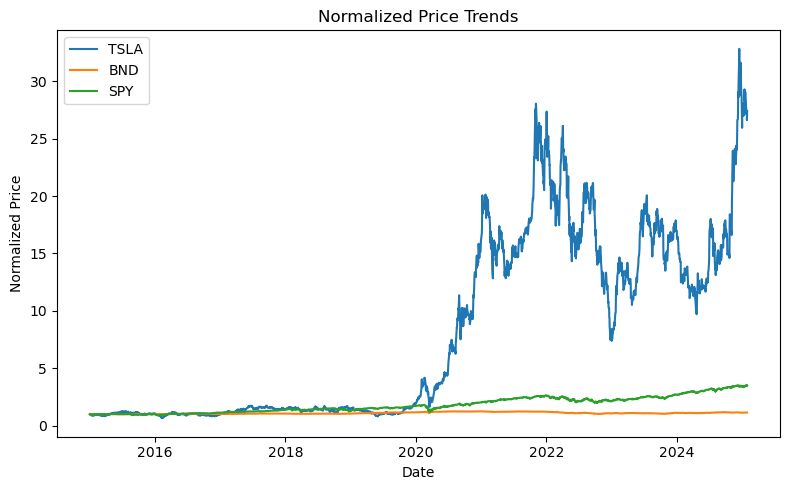

In [15]:
# EXPLORATORY DATA ANALYSIS
# Calculate daily returns
returns = prices.pct_change().dropna()

# Plot the price trends
plt.figure(figsize=(8, 5))
for asset in assets:
    plt.plot(prices.index, prices[asset]/prices[asset].iloc[0], label=asset)
plt.title('Normalized Price Trends')
plt.ylabel('Normalized Price')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

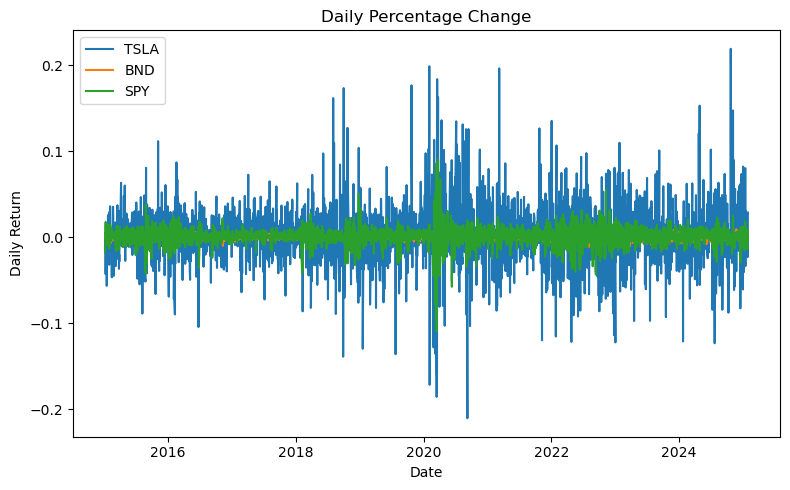

In [16]:
# Plote teh change percentage
plt.figure(figsize=(8,5))
for ticker in assets:
    plt.plot(returns.index, returns[ticker], label=ticker)
plt.title("Daily Percentage Change")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.tight_layout()

In [13]:
# Calculate and display key statistics
print("\nSummary statistics of daily returns:")
summary_stats = returns.describe().T
summary_stats['annualized_return'] = returns.mean() * 252
summary_stats['annualized_volatility'] = returns.std() * np.sqrt(252)
summary_stats['sharpe_ratio'] = summary_stats['annualized_return'] / summary_stats['annualized_volatility']
print(summary_stats[['annualized_return', 'annualized_volatility', 'sharpe_ratio']])



Summary statistics of daily returns:
        annualized_return  annualized_volatility  sharpe_ratio
Ticker                                                        
BND              0.015721               0.054400      0.288983
SPY              0.140314               0.175939      0.797518
TSLA             0.491944               0.571570      0.860690



Testing stationarity of TSLA prices:
ADF Statistic: -0.5687
p-value: 0.8779
Critical Values:
	1%: -3.4330
	5%: -2.8627
	10%: -2.5674
Result: The series is non-stationary (fail to reject H0)

Testing stationarity of TSLA returns:
ADF Statistic: -34.5975
p-value: 0.0000
Critical Values:
	1%: -3.4329
	5%: -2.8627
	10%: -2.5674
Result: The series is stationary (reject H0)

Decomposing TSLA price series:

Fitting ARIMA model...
                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 2280
Model:                 ARIMA(2, 1, 1)   Log Likelihood                4369.120
Date:                Fri, 28 Feb 2025   AIC                          -8730.241
Time:                        15:40:17   BIC                          -8707.315
Sample:                             0   HQIC                         -8721.878
                               - 2280                                         
Covariance Type:   

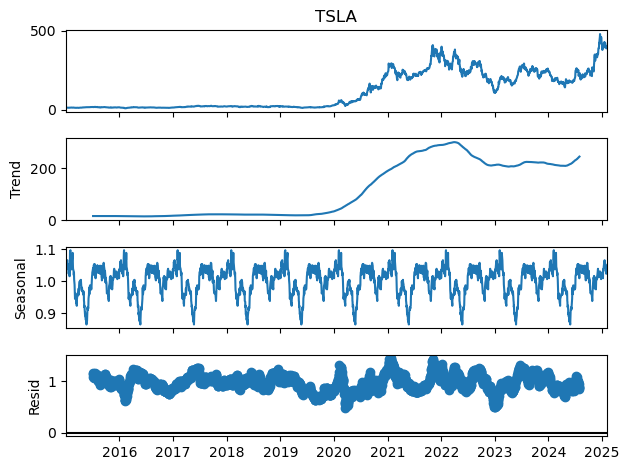

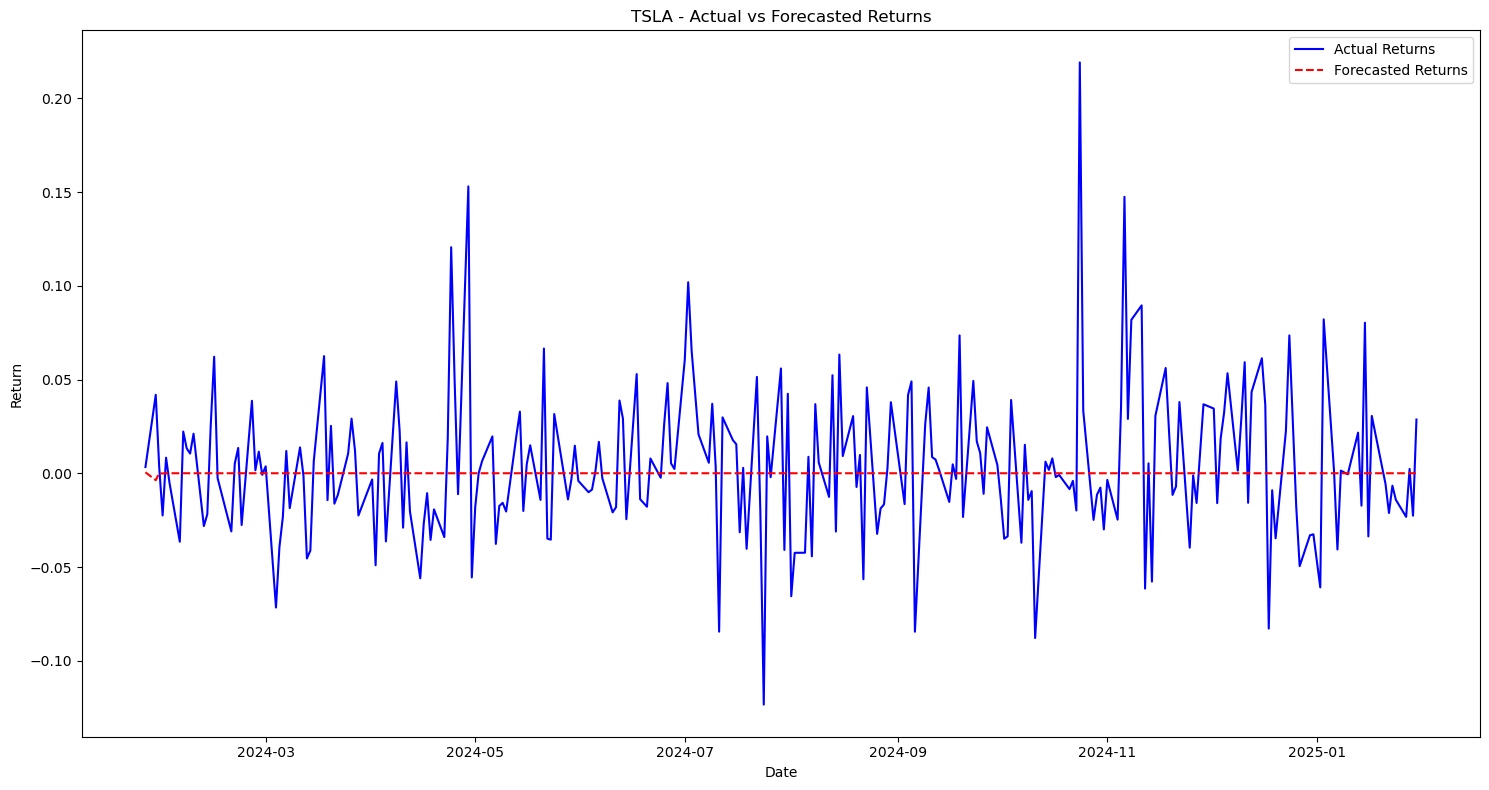

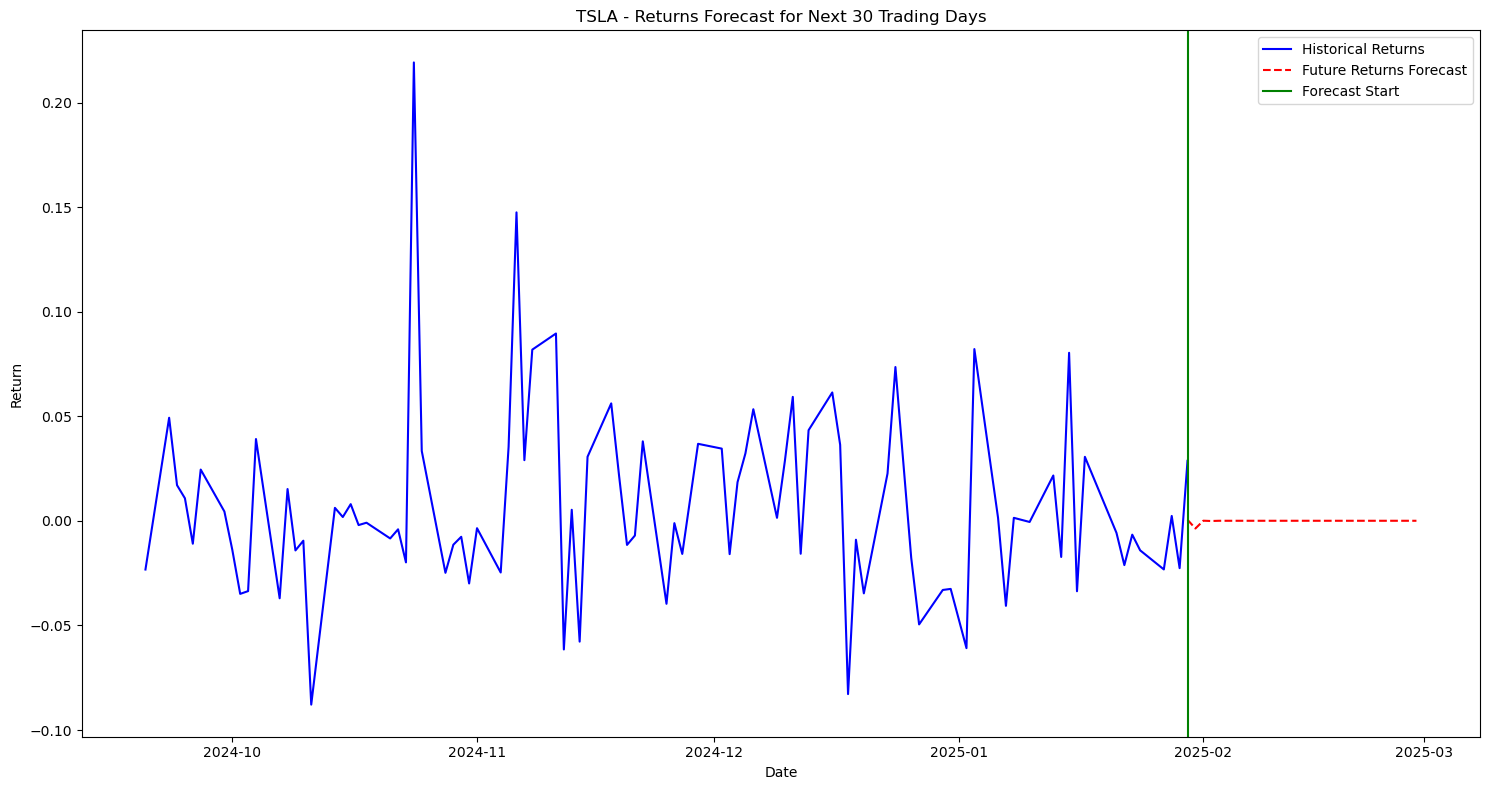

In [32]:
# TIME SERIES ANALYSIS AND FORECASTING

# For the forecasting demo, we'll focus on just one asset (Apple)
forecast_asset = 'TSLA'
asset_price = prices[forecast_asset]
asset_returns = returns[forecast_asset]

# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print("Result: The series is stationary (reject H0)")
    else:
        print("Result: The series is non-stationary (fail to reject H0)")

print(f"\nTesting stationarity of {forecast_asset} prices:")
check_stationarity(asset_price)

print(f"\nTesting stationarity of {forecast_asset} returns:")
check_stationarity(asset_returns)

# Time series decomposition
print(f"\nDecomposing {forecast_asset} price series:")
decomposition = seasonal_decompose(asset_price, model='multiplicative', period=252)  # 252 trading days in a year
fig = decomposition.plot()
plt.tight_layout()

# Fit an ARIMA model
print("\nFitting ARIMA model...")

# Prepare training data (use 90% for training)
train_size = int(len(asset_returns) * 0.9)
train_data = asset_returns.iloc[:train_size]
test_data = asset_returns.iloc[train_size:]

# Fit ARIMA model
p, d, q = 2, 1, 1  # Example parameters, would be determined by analysis in practice
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Forecast and evaluate
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

# Calculate error metrics
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"\nModel Evaluation on Test Data:")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

# Plot actual vs forecast returns
plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data, label='Actual Returns', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Returns', color='red', linestyle='--')
plt.title(f'{forecast_asset} - Actual vs Forecasted Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()

# Generate and plot future forecasts
future_steps = 30  # Forecast 30 days ahead
future_forecast = model_fit.forecast(steps=future_steps)
future_dates = pd.date_range(start=asset_returns.index[-1], periods=future_steps)

plt.figure(figsize=(15, 8))
plt.plot(asset_returns.index[-90:], asset_returns.iloc[-90:], label='Historical Returns', color='blue')
plt.plot(future_dates, future_forecast, label='Future Returns Forecast', color='red', linestyle='--')
plt.title(f'{forecast_asset} - Returns Forecast for Next {future_steps} Trading Days')
plt.xlabel('Date')
plt.ylabel('Return')
plt.axvline(x=asset_returns.index[-1], color='green', linestyle='-', label='Forecast Start')
plt.legend()
plt.tight_layout()



Testing stationarity of BND prices:
ADF Statistic: -1.4723
p-value: 0.5472
Critical Values:
	1%: -3.4330
	5%: -2.8627
	10%: -2.5674
Result: The series is non-stationary (fail to reject H0)

Testing stationarity of BND returns:
ADF Statistic: -9.9811
p-value: 0.0000
Critical Values:
	1%: -3.4330
	5%: -2.8627
	10%: -2.5674
Result: The series is stationary (reject H0)

Decomposing BND price series:

Fitting ARIMA model...


c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    BND   No. Observations:                 2280
Model:                 ARIMA(1, 0, 1)   Log Likelihood                9704.923
Date:                Fri, 28 Feb 2025   AIC                         -19401.846
Time:                        15:14:56   BIC                         -19378.918
Sample:                             0   HQIC                        -19393.483
                               - 2280                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.502e-05   7.75e-05      0.710      0.478   -9.69e-05       0.000
ar.L1          0.5830      0.303      1.927      0.054      -0.010       1.176
ma.L1         -0.5996      0.301     -1.991      0.0

c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\hp\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


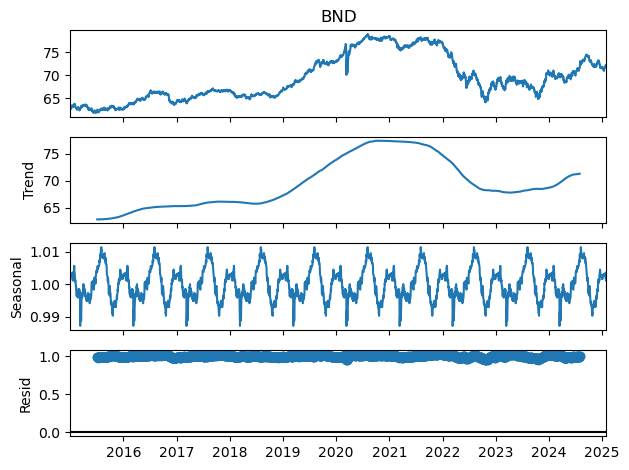

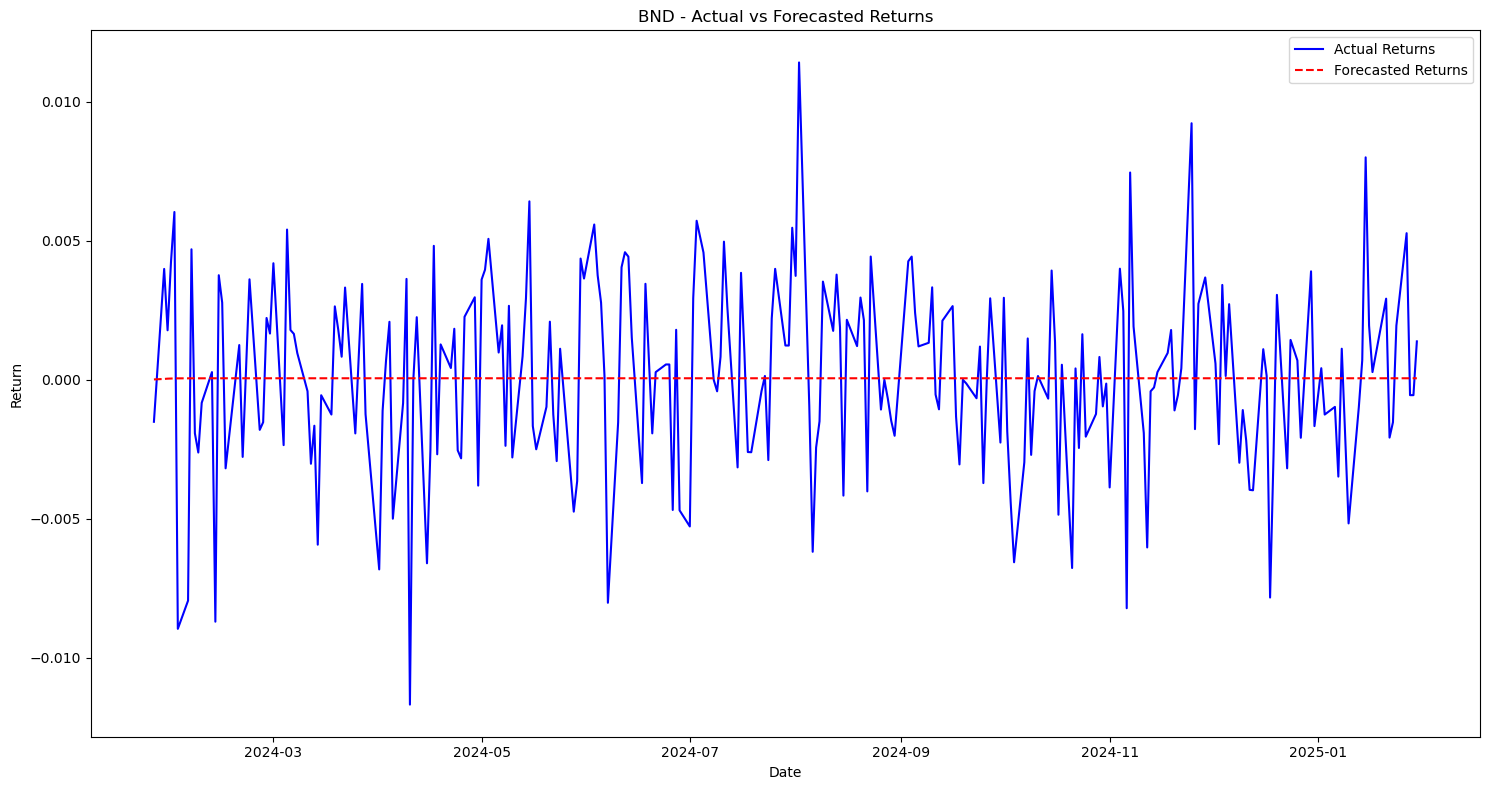

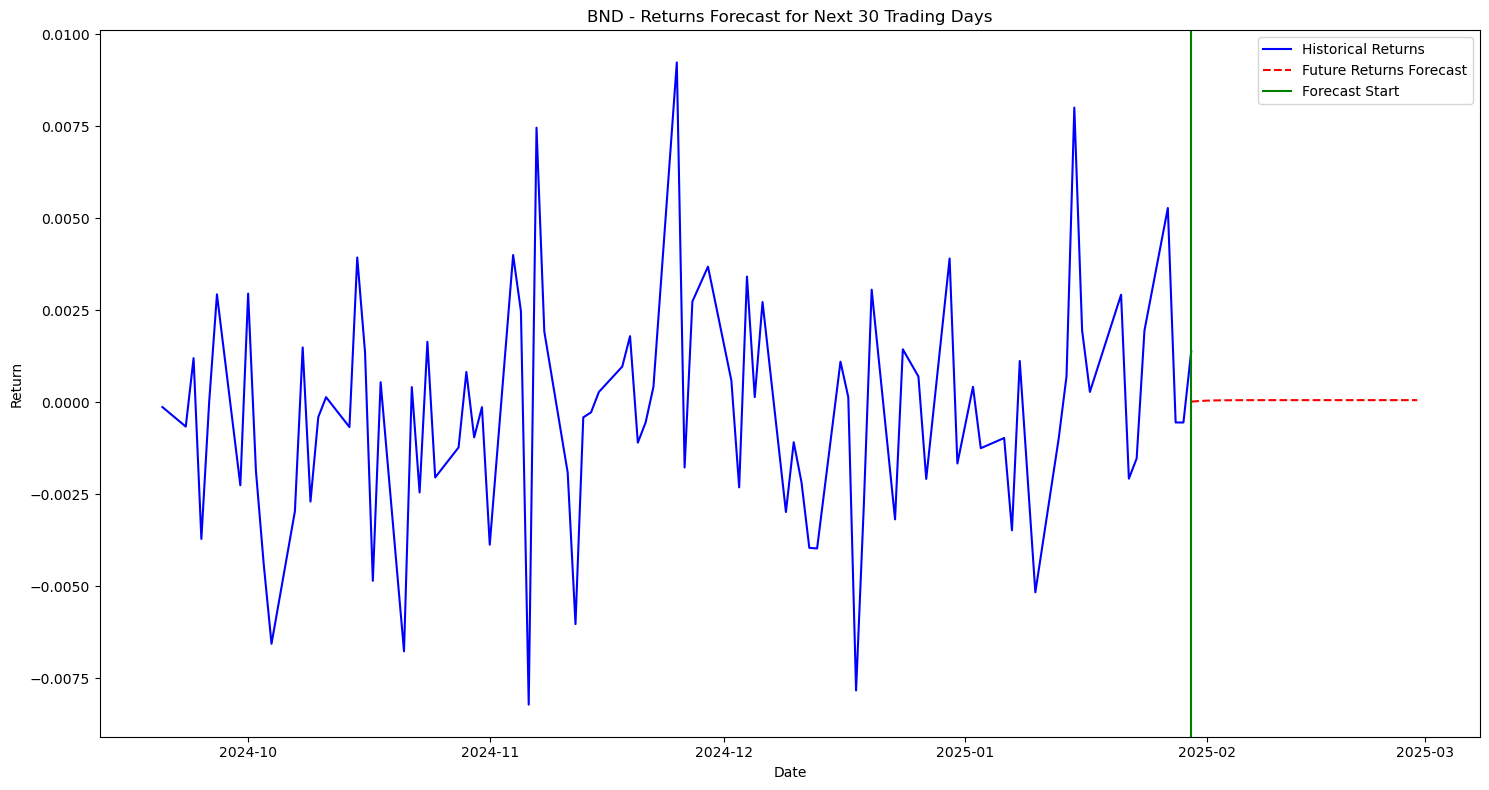

In [24]:
# TIME SERIES ANALYSIS AND FORECASTING

# For the forecasting demo, we'll focus on just one asset (Apple)
forecast_asset = 'BND'
asset_price = prices[forecast_asset]
asset_returns = returns[forecast_asset]

# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print("Result: The series is stationary (reject H0)")
    else:
        print("Result: The series is non-stationary (fail to reject H0)")

print(f"\nTesting stationarity of {forecast_asset} prices:")
check_stationarity(asset_price)

print(f"\nTesting stationarity of {forecast_asset} returns:")
check_stationarity(asset_returns)

# Time series decomposition
print(f"\nDecomposing {forecast_asset} price series:")
decomposition = seasonal_decompose(asset_price, model='multiplicative', period=252)  # 252 trading days in a year
fig = decomposition.plot()
plt.tight_layout()

# Fit an ARIMA model
print("\nFitting ARIMA model...")

# Prepare training data (use 90% for training)
train_size = int(len(asset_returns) * 0.9)
train_data = asset_returns.iloc[:train_size]
test_data = asset_returns.iloc[train_size:]

# Fit ARIMA model
p, d, q = 1, 0, 1  # Example parameters, would be determined by analysis in practice
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Forecast and evaluate
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

# Calculate error metrics
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"\nModel Evaluation on Test Data:")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

# Plot actual vs forecast returns
plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data, label='Actual Returns', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Returns', color='red', linestyle='--')
plt.title(f'{forecast_asset} - Actual vs Forecasted Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()

# Generate and plot future forecasts
future_steps = 30  # Forecast 30 days ahead
future_forecast = model_fit.forecast(steps=future_steps)
future_dates = pd.date_range(start=asset_returns.index[-1], periods=future_steps)

plt.figure(figsize=(15, 8))
plt.plot(asset_returns.index[-90:], asset_returns.iloc[-90:], label='Historical Returns', color='blue')
plt.plot(future_dates, future_forecast, label='Future Returns Forecast', color='red', linestyle='--')
plt.title(f'{forecast_asset} - Returns Forecast for Next {future_steps} Trading Days')
plt.xlabel('Date')
plt.ylabel('Return')
plt.axvline(x=asset_returns.index[-1], color='green', linestyle='-', label='Forecast Start')
plt.legend()
plt.tight_layout()



Testing stationarity of SPY prices:
ADF Statistic: 0.9362
p-value: 0.9935
Critical Values:
	1%: -3.4329
	5%: -2.8627
	10%: -2.5674
Result: The series is non-stationary (fail to reject H0)

Testing stationarity of SPY returns:
ADF Statistic: -15.9593
p-value: 0.0000
Critical Values:
	1%: -3.4329
	5%: -2.8627
	10%: -2.5674
Result: The series is stationary (reject H0)

Decomposing SPY price series:

Fitting ARIMA model...
                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                 2280
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6985.737
Date:                Fri, 28 Feb 2025   AIC                         -13963.474
Time:                        15:41:45   BIC                         -13940.548
Sample:                             0   HQIC                        -13955.112
                               - 2280                                         
Covariance Type:       

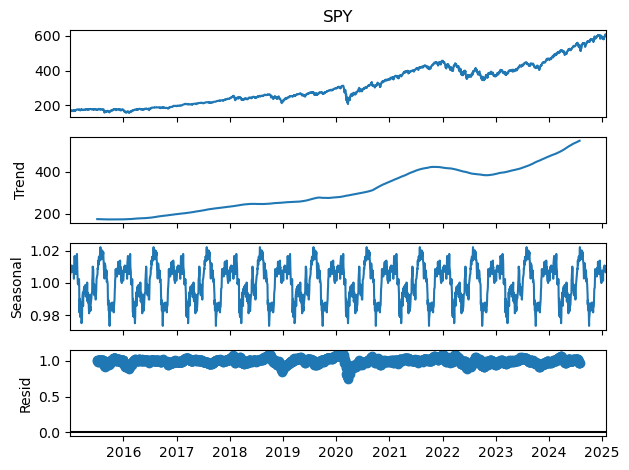

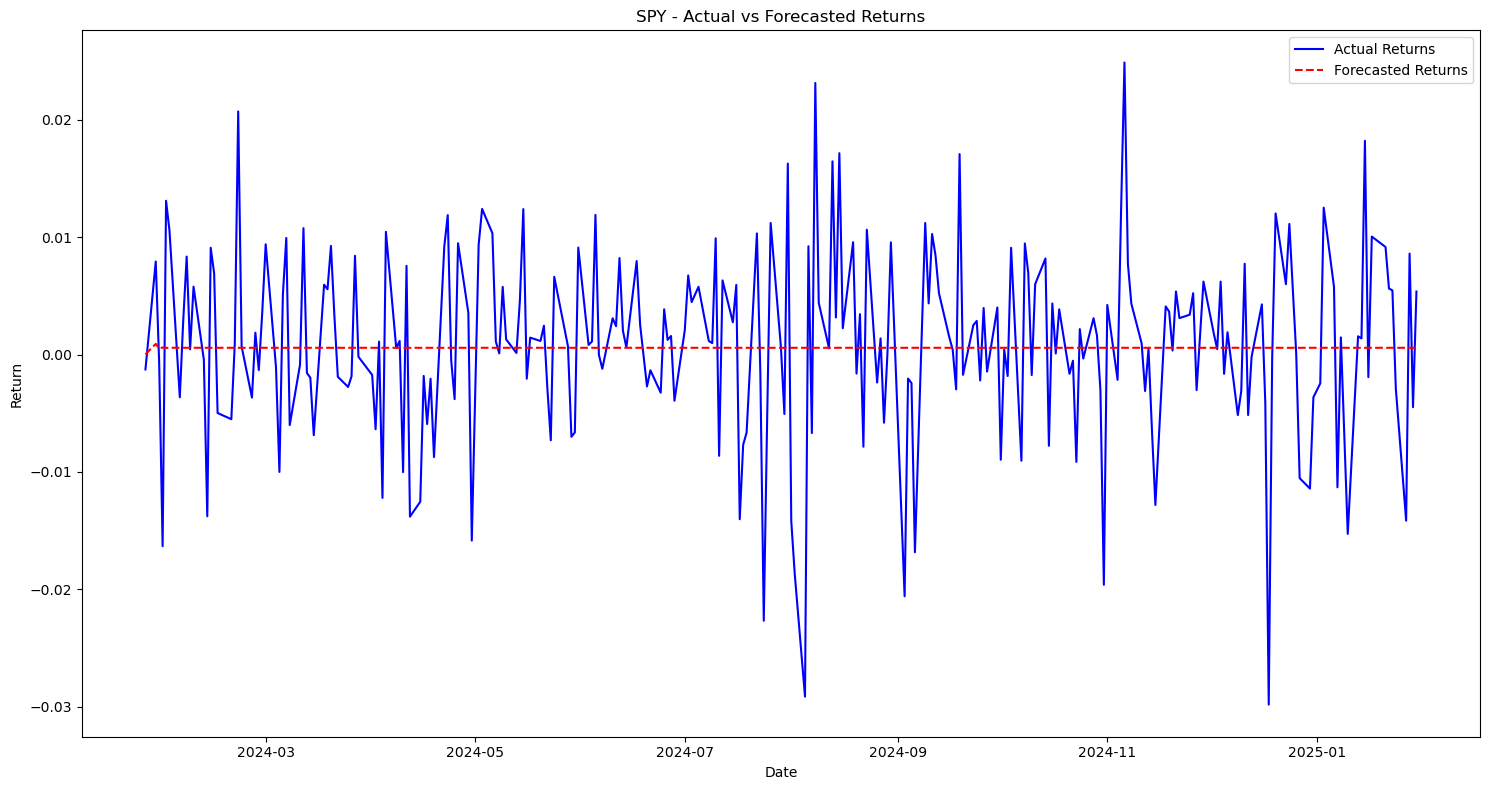

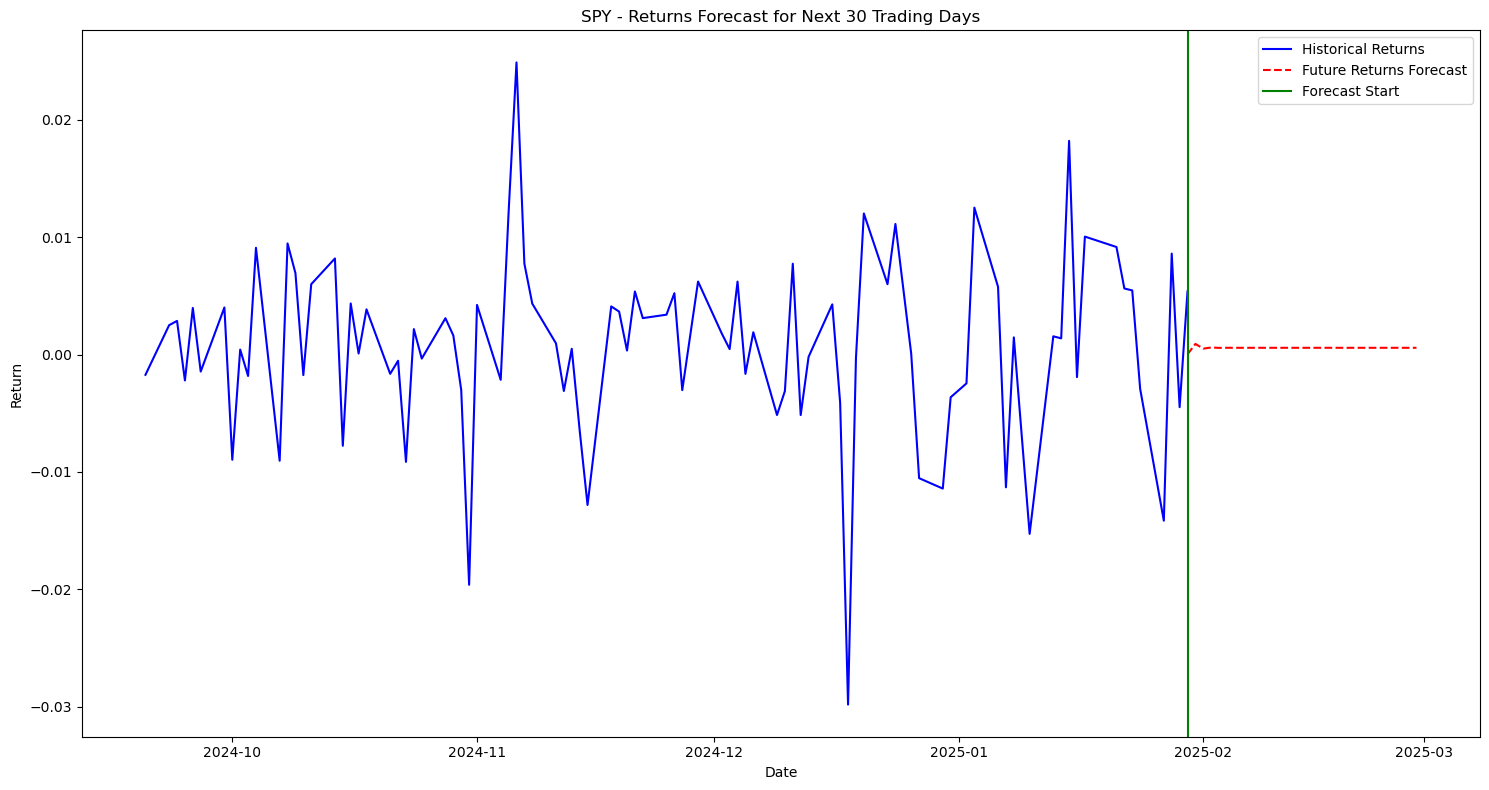

In [33]:
# TIME SERIES ANALYSIS AND FORECASTING

# For the forecasting demo, we'll focus on just one asset (Apple)
forecast_asset = 'SPY'
asset_price = prices[forecast_asset]
asset_returns = returns[forecast_asset]

# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print("Result: The series is stationary (reject H0)")
    else:
        print("Result: The series is non-stationary (fail to reject H0)")

print(f"\nTesting stationarity of {forecast_asset} prices:")
check_stationarity(asset_price)

print(f"\nTesting stationarity of {forecast_asset} returns:")
check_stationarity(asset_returns)

# Time series decomposition
print(f"\nDecomposing {forecast_asset} price series:")
decomposition = seasonal_decompose(asset_price, model='multiplicative', period=252)  # 252 trading days in a year
fig = decomposition.plot()
plt.tight_layout()

# Fit an ARIMA model
print("\nFitting ARIMA model...")

# Prepare training data (use 90% for training)
train_size = int(len(asset_returns) * 0.9)
train_data = asset_returns.iloc[:train_size]
test_data = asset_returns.iloc[train_size:]

# Fit ARIMA model
p, d, q = 2, 1, 1  # Example parameters, would be determined by analysis in practice
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Forecast and evaluate
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

# Calculate error metrics
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"\nModel Evaluation on Test Data:")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

# Plot actual vs forecast returns
plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data, label='Actual Returns', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Returns', color='red', linestyle='--')
plt.title(f'{forecast_asset} - Actual vs Forecasted Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()

# Generate and plot future forecasts
future_steps = 30  # Forecast 30 days ahead
future_forecast = model_fit.forecast(steps=future_steps)
future_dates = pd.date_range(start=asset_returns.index[-1], periods=future_steps)

plt.figure(figsize=(15, 8))
plt.plot(asset_returns.index[-90:], asset_returns.iloc[-90:], label='Historical Returns', color='blue')
plt.plot(future_dates, future_forecast, label='Future Returns Forecast', color='red', linestyle='--')
plt.title(f'{forecast_asset} - Returns Forecast for Next {future_steps} Trading Days')
plt.xlabel('Date')
plt.ylabel('Return')
plt.axvline(x=asset_returns.index[-1], color='green', linestyle='-', label='Forecast Start')
plt.legend()
plt.tight_layout()
